# Trabajo Práctico 2

## Page Rank de Actores y Actrices

In [ ]:
import os
from bs4 import BeautifulSoup

DIR = 'TP2/paginas'
PAGINAS = os.listdir(DIR)

links = [] # Lista de tuplas de src->dst
palabras = {} # Dict de pagina: palabras

for f in PAGINAS:
    with open(os.path.join(DIR, f)) as file:
        soup = BeautifulSoup(file.read())
        palabras[f] = soup.get_text().split()

        for link in soup.find_all('a'):
            dst = link.get('href').replace('http://','')
            links.append((f,dst))

links

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    'figure.figsize': (10, 6),
}
pylab.rcParams.update(params)

In [ ]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(links)
nx.draw_shell(G, with_labels=True, node_color='white', edge_color='grey')

In [ ]:
matriz_ady = nx.to_pandas_adjacency(G)
matriz_ady

In [ ]:
suma_filas = matriz_ady.sum(axis=1)
matriz_page_rank = matriz_ady.div(suma_filas, axis=0)
matriz_page_rank.fillna(1/len(PAGINAS), inplace=True)
matriz_page_rank

In [ ]:
import numpy as np

# Hacemos N iteraciones de la matriz
iteraciones = np.linalg.matrix_power(matriz_page_rank, 50)

page_rank = {p: iteraciones[0][i] for i, p in enumerate(matriz_page_rank.index)}
page_rank

In [ ]:
import random

BUSQUEDAS = 20

todas_palabras = set()
for p in palabras.values():
    todas_palabras.update(p)

for p in random.choices(list(todas_palabras), k=BUSQUEDAS):
    matches = [f for f in PAGINAS if p in palabras[f]]
    print(f"'{p}' aparece en: {sorted(matches, key=lambda x: -page_rank[x])}")

# Diseño del Web Service

In [5]:
from scipy.stats import expon, uniform
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from math import floor

sns.set(style="darkgrid")
params = {
    'axes.titlesize': 20,
    'axes.labelsize': 15,
    'legend.fontsize': 20,
    'figure.figsize': (10, 6),
}
pylab.rcParams.update(params)

In [6]:
class Consulta:
    def __init__(self, tiempo_arribo, duracion, tiempo_finalizacion_anterior):
        if tiempo_arribo < tiempo_finalizacion_anterior:
            self.duracion_espera = tiempo_finalizacion_anterior - tiempo_arribo
            self.tuvo_que_esperar = True
        else:
            self.duracion_espera = 0
            self.tuvo_que_esperar = False
                            
        self.tiempo_finalizacion = tiempo_arribo + duracion + self.duracion_espera

In [7]:
def simular_consultas(tiempos_de_arribo, duraciones):
    consultas = []

    # Uso -1 como tiempo de finalizacion del anterior para que empieze ni bien llega
    primera_consulta = Consulta(tiempos_de_arribo[0], duraciones[0], tiempo_finalizacion_anterior = -1)
    consultas.append(primera_consulta)

    for tiempo_arribo, duracion in zip(tiempos_de_arribo[1:], duraciones[1:]):
        consulta = Consulta(tiempo_arribo,
                        duracion, 
                        tiempo_finalizacion_anterior = consultas[-1].tiempo_finalizacion)
        consultas.append(consulta)
        
    tiempo_espera_total = 0
    cant_consultas_que_no_esperaron = 0
    for consulta in consultas:
        tiempo_espera_total += consulta.duracion_espera
        if not consulta.tuvo_que_esperar:
            cant_consultas_que_no_esperaron += 1

    return tiempo_espera_total, cant_consultas_que_no_esperaron

### Centralizado

In [8]:
def mostrar_resultados(titulo, tiempo_espera_total, cant_consultas_que_no_esperaron, cant_consultas):
    print(f"--------------{titulo}--------------")
    
    
    segundos = round(tiempo_espera_total / cant_consultas, 0)
    
    minutos = floor(segundos/60)
    if(minutos != 0):
        segundos = segundos % (minutos * 60)
    
    horas = floor(minutos/60)
    if(horas != 0):
        minutos = minutos % (horas * 60)

        
    dias = floor(horas/24)
    if(dias != 0):
        horas = horas % (dias * 24)
    
    print(f"\tEl tiempo de espera promedio fue ", end="")
    if(dias != 0):
        print(str(dias) + " Dias ", end="")
    if(horas != 0):    
        print(str(horas) + " Horas ", end="")
    if(minutos != 0):    
        print(str(minutos) + " Minutos ", end="")
    if(segundos != 0):    
        print(str(segundos) + " Segundos")
    
    
    print(f"\tEl {round(cant_consultas_que_no_esperaron/cant_consultas, 5)}% de las consultas no tuvo que esperar")

In [9]:
def simular_consultas_centralizado(cant_consultas, media_tiempos_de_arribo, media_duraciones_consultas):
    tiempos_de_arribo = expon.rvs(size=cant_consultas, scale=media_tiempos_de_arribo, random_state=10)
    duraciones = expon.rvs(size=cant_consultas, scale=media_duraciones_consultas, random_state=10)
    return simular_consultas(tiempos_de_arribo, duraciones)

In [10]:
t, f = simular_consultas_centralizado(100000, 4, 0.8)
mostrar_resultados("Base de datos central", t,f, 100000)

--------------Base de datos central--------------
	El tiempo de espera promedio fue 11 Horas 3 Minutos 16.0 Segundos
	El 2e-05% de las consultas no tuvo que esperar


### Distribuido

In [11]:
def simular_consultas_distribuido(cant_consultas, media_tiempos_de_arribo,
                                  media_duraciones_consultas1, media_duraciones_consultas2, p):
    tiempos_de_arribo = expon.rvs(size=cant_consultas, scale=media_tiempos_de_arribo, random_state=10)
    u = uniform.rvs(size=cant_consultas, random_state=10)
    
    tiempos_de_arribo1 = []
    tiempos_de_arribo2 = []
    
    for ui, tiempo_de_arribo in zip(u, tiempos_de_arribo):
        if p <= ui:
            tiempos_de_arribo1.append(tiempo_de_arribo)
        else:
            tiempos_de_arribo2.append(tiempo_de_arribo)
    
    
    duraciones1 = expon.rvs(size=len(tiempos_de_arribo1), scale=media_duraciones_consultas1, random_state=10)
    t1, f1 = simular_consultas(tiempos_de_arribo1, duraciones1)
    
    duraciones2 = expon.rvs(size=len(tiempos_de_arribo2), scale=media_duraciones_consultas2, random_state=10)
    t2, f2 = simular_consultas(tiempos_de_arribo2, duraciones2)
    
    return t1, f1, len(tiempos_de_arribo1), t2, f2, len(tiempos_de_arribo2)

In [12]:
t1, f1, l1, t2, f2, l2 = simular_consultas_distribuido(100000, 4, 0.7, 1, 0.7)
mostrar_resultados("Ambas bases distribuidas", t1 + t2, f2 + f2, l1 + l2)
mostrar_resultados("Base de datos distribuida 1", t1, f1, l1)
mostrar_resultados("Base de datos distribuida 2", t2, f2, l2)

--------------Ambas bases distribuidas--------------
	El tiempo de espera promedio fue 7 Horas 40 Minutos 21.0 Segundos
	El 4e-05% de las consultas no tuvo que esperar
--------------Base de datos distribuida 1--------------
	El tiempo de espera promedio fue 2 Horas 51 Minutos 34.0 Segundos
	El 7e-05% de las consultas no tuvo que esperar
--------------Base de datos distribuida 2--------------
	El tiempo de espera promedio fue 9 Horas 42 Minutos 30.0 Segundos
	El 3e-05% de las consultas no tuvo que esperar


### Modificando los parametros

In [13]:
def simular_variaciones(cantidades_consultas=[100000], 
                        medias_tiempos_de_arribo=[4],
                        medias_duraciones_consultas = [0.8],  
                        medias_duraciones_consultas1 = [0.7],
                        medias_duraciones_consultas2 = [1],
                        lista_p = [0.7]):

    tiempos_centralizado = []
    frecuencias_centralizado = []

    tiempos_distribuido = []
    frecuencias_distribuido = []
                         
    for cant_consultas in cantidades_consultas:
        for media_tiempos_de_arribo in medias_tiempos_de_arribo:
            for media_duraciones_consultas in medias_duraciones_consultas:
                for media_duraciones_consultas1 in medias_duraciones_consultas1:
                     for media_duraciones_consultas2 in medias_duraciones_consultas2:
                            for p in lista_p:
                                t, f = simular_consultas_centralizado(cant_consultas, media_tiempos_de_arribo, 
                                                                      media_duraciones_consultas)
                                tiempos_centralizado.append(t / cant_consultas)
                                frecuencias_centralizado.append(f /cant_consultas)
    
                                t1, f1, l1, t2, f2, l2  = simular_consultas_distribuido(cant_consultas, 
                                                                                        media_tiempos_de_arribo,
                                                                                        media_duraciones_consultas1,
                                                                                        media_duraciones_consultas2,
                                                                                        p)
    
                                tiempos_distribuido.append((t1 + t2) / (l1 + l2))
                                frecuencias_distribuido.append((f1 + f2) / (l1 + l2))
            
            
    return tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido 

In [14]:
def graficar_tiempo_espera(x, xlabel, tiempos_centralizado, tiempos_distribuido,
                         centralizado_es_referencia = False, distribuido_es_referencia = False):
    
    if centralizado_es_referencia:
        color_centralizado = 'b'
        linestyle_centralizado = '--'
    else:
        color_centralizado = 'bo'
        linestyle_centralizado = '-'
        
    if distribuido_es_referencia:
        color_distribuido = 'g'
        linestyle_distribuido = '--'
    else:
        color_distribuido = 'go'
        linestyle_distribuido = '-'
    
    plt.plot(x, tiempos_centralizado, color_centralizado, linestyle=linestyle_centralizado, label="Base centralizada")
    plt.plot(x, tiempos_distribuido, color_distribuido, linestyle=linestyle_distribuido, label="Bases distribuidas")
    plt.title(f"Tiempo de espera medio según\n{xlabel.lower()}")
    plt.xlabel(xlabel)
    plt.ylabel("Tiempo de espera medio")
    plt.legend()
    plt.show()

In [15]:
def graficar_fraccion_que_no_espero(x, xlabel, tiempos_centralizado, tiempos_distribuido,
    centralizado_es_referencia = False, distribuido_es_referencia = False):
    
    if centralizado_es_referencia:
        color_centralizado = 'b'
        linestyle_centralizado = '--'
    else:
        color_centralizado = 'bo'
        linestyle_centralizado = '-'
        
    if distribuido_es_referencia:
        color_distribuido = 'g'
        linestyle_distribuido = '--'
    else:
        color_distribuido = 'go'
        linestyle_distribuido = '-'
    
    plt.plot(x, tiempos_centralizado, color_centralizado, linestyle=linestyle_centralizado, label="Base centralizada")
    plt.plot(x, tiempos_distribuido, color_distribuido, linestyle=linestyle_distribuido, label="Bases distribuidas")
    plt.title(f"Fracción de solicitudes que no esperaron según\n{xlabel.lower()}")
    plt.xlabel(xlabel)
    plt.ylabel("Fracción de solicitudes que no esperaron")
    plt.legend()

#### Media del tiempo de arribo

In [16]:
medias_tiempos_de_arribo = range(1, 11)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
    medias_tiempos_de_arribo = medias_tiempos_de_arribo
)

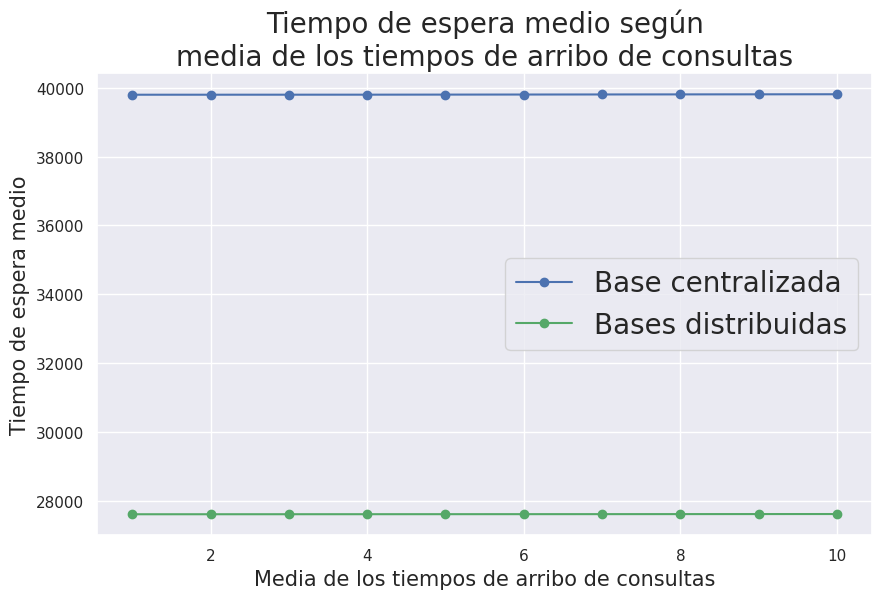

In [17]:
graficar_tiempo_espera(medias_tiempos_de_arribo, "Media de los tiempos de arribo de consultas",
                      tiempos_centralizado, tiempos_distribuido)

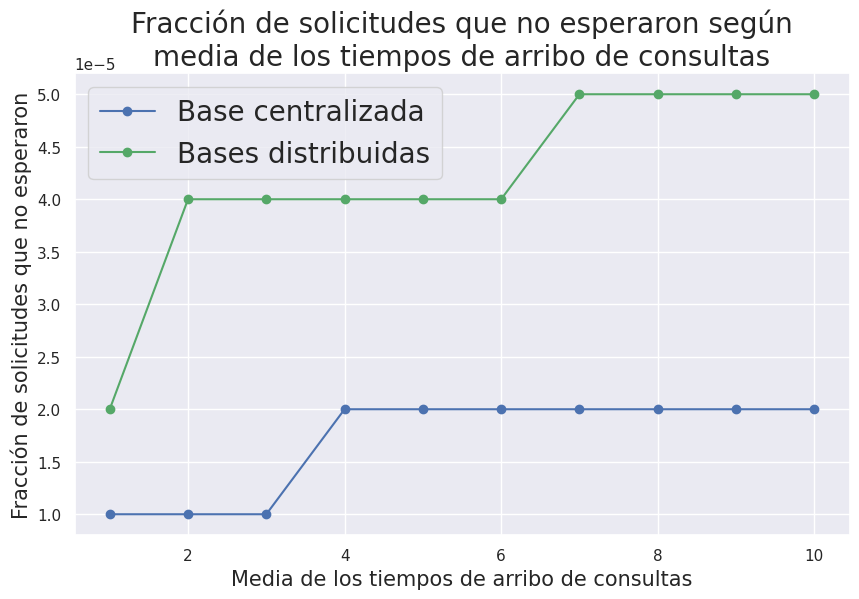

In [18]:
graficar_fraccion_que_no_espero(medias_tiempos_de_arribo, "Media de los tiempos de arribo de consultas",
                      frecuencias_centralizado, frecuencias_distribuido)

#### Lambda

In [19]:
lambda_l = []
for i in range(2, 20, 2):
    lambda_l.append(i/10)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
     medias_duraciones_consultas = lambda_l
)

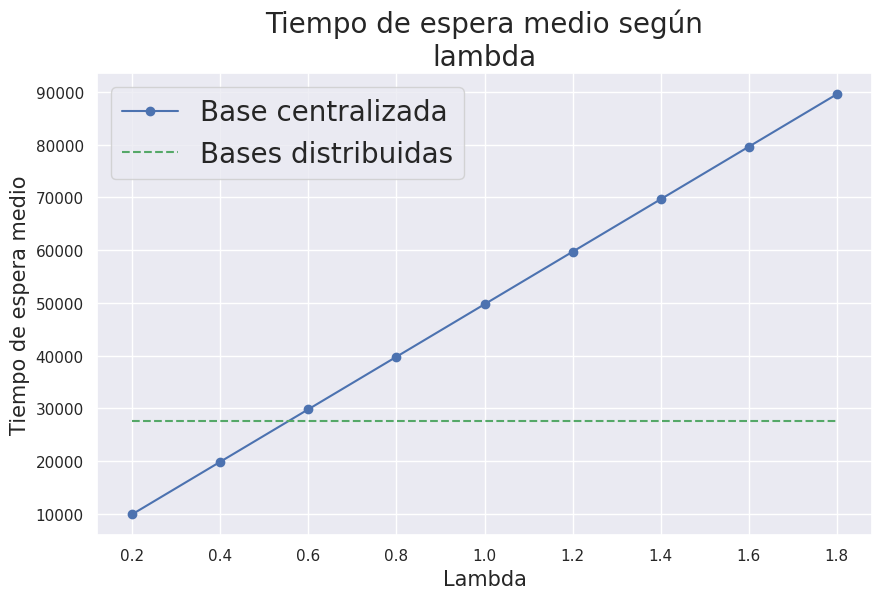

In [20]:
graficar_tiempo_espera(lambda_l, "Lambda",
                      tiempos_centralizado, tiempos_distribuido, distribuido_es_referencia = True)

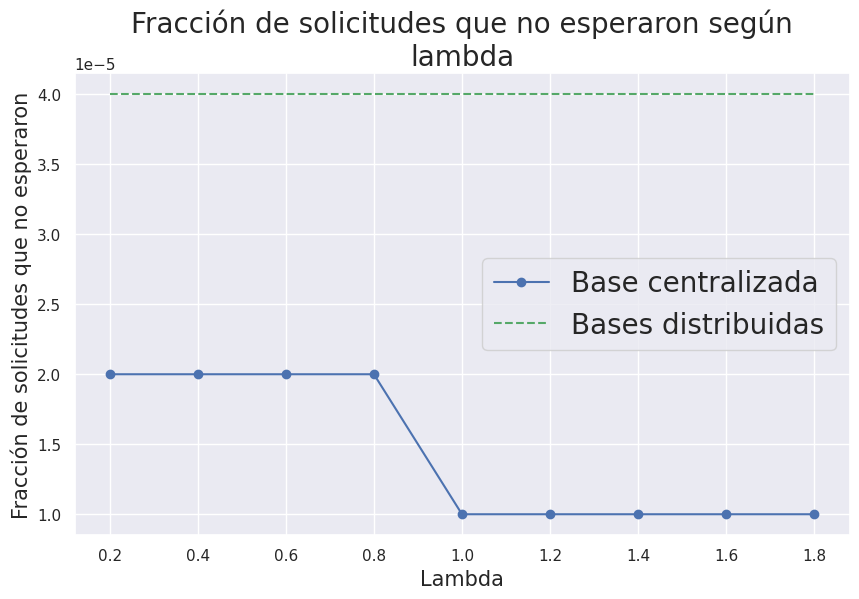

In [21]:
graficar_fraccion_que_no_espero(lambda_l, "Lambda",
                      frecuencias_centralizado, frecuencias_distribuido, distribuido_es_referencia = True)

#### Lambda1

In [22]:
lambda_1 = []
for i in range(2, 20, 2):
    lambda_1.append(i/10)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
     medias_duraciones_consultas1 = lambda_1
)

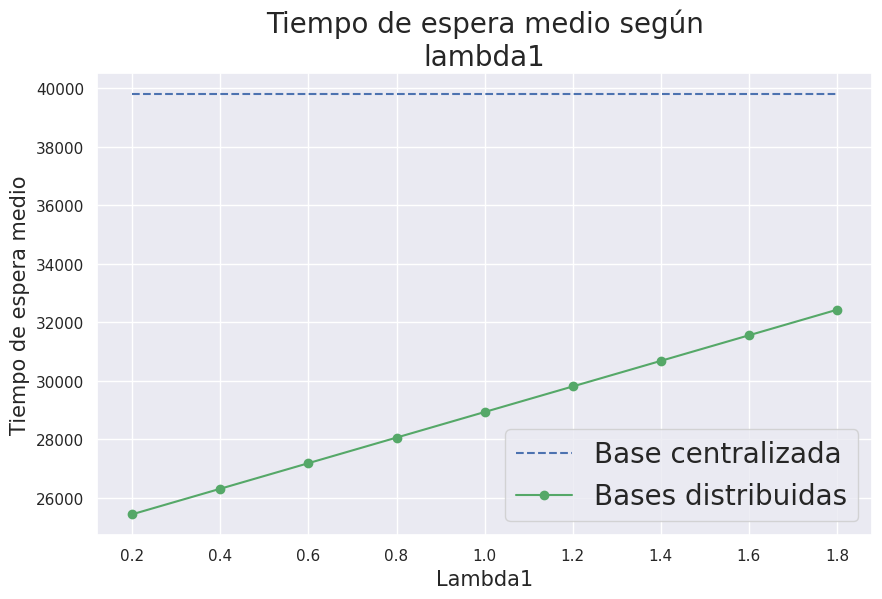

In [23]:
graficar_tiempo_espera(lambda_1, "Lambda1",
                      tiempos_centralizado, tiempos_distribuido, centralizado_es_referencia = True)

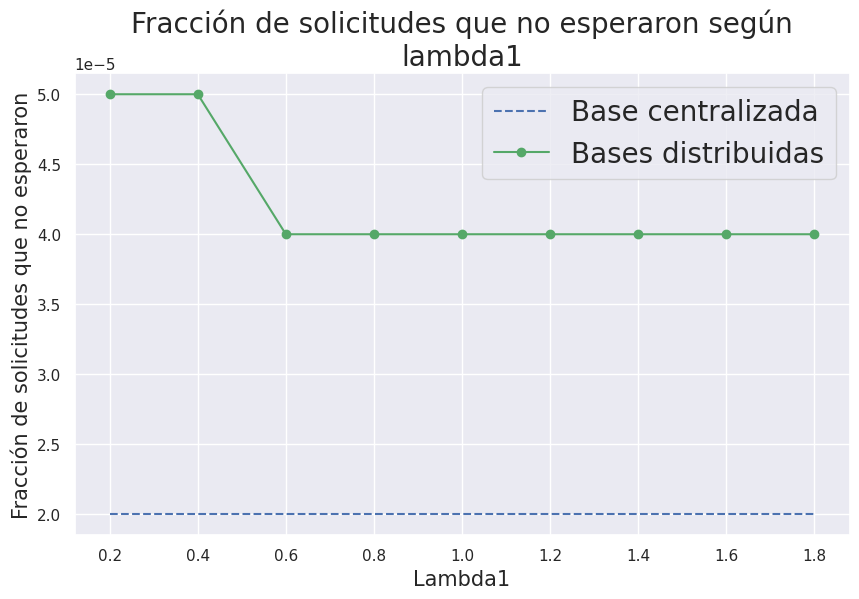

In [24]:
graficar_fraccion_que_no_espero(lambda_1, "Lambda1",
                      frecuencias_centralizado, frecuencias_distribuido, centralizado_es_referencia = True)

#### Lambda2

In [25]:
lambda_2 = []
for i in range(2, 20, 2):
    lambda_2.append(i/10)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
     medias_duraciones_consultas1 = lambda_2
)

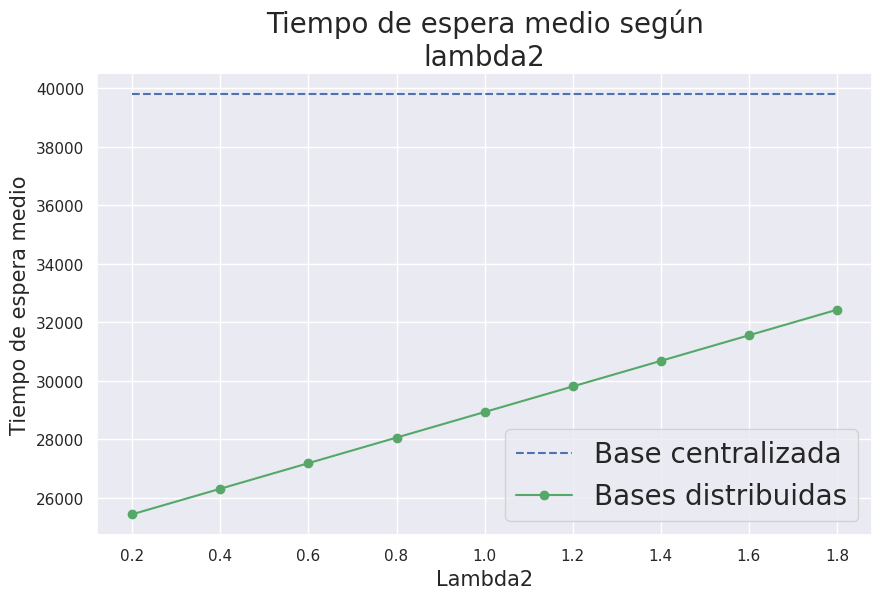

In [26]:
graficar_tiempo_espera(lambda_2, "Lambda2",
                      tiempos_centralizado, tiempos_distribuido, centralizado_es_referencia = True)

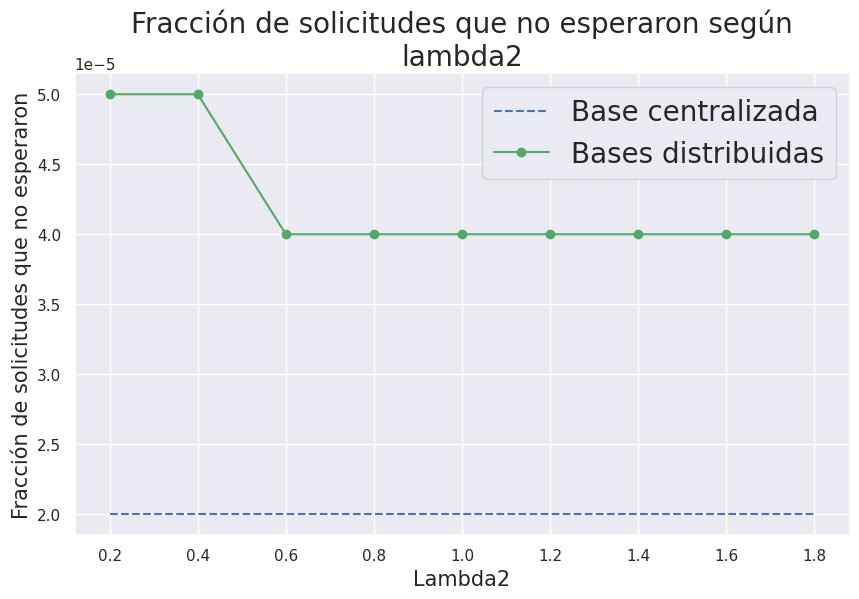

In [27]:
graficar_fraccion_que_no_espero(lambda_2, "Lambda2",
                      frecuencias_centralizado, frecuencias_distribuido, centralizado_es_referencia = True)

#### p

In [28]:
lista_p = []
for i in range(1, 10):
    lista_p.append(i/10)
tiempos_centralizado, frecuencias_centralizado, tiempos_distribuido, frecuencias_distribuido = simular_variaciones(
     lista_p = lista_p
)

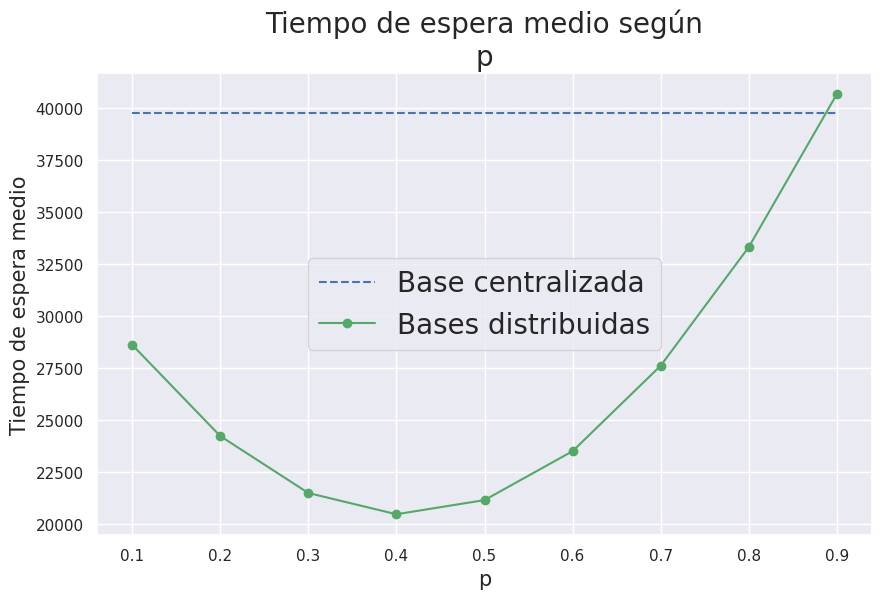

In [29]:
graficar_tiempo_espera(lista_p, "p",
                      tiempos_centralizado, tiempos_distribuido, centralizado_es_referencia = True)

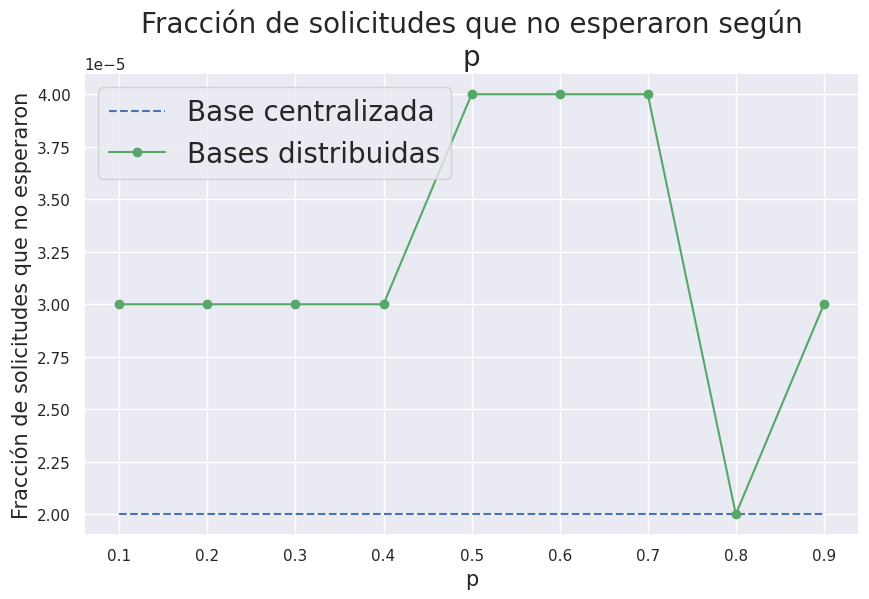

In [30]:
graficar_fraccion_que_no_espero(lista_p, "p",
                      frecuencias_centralizado, frecuencias_distribuido, centralizado_es_referencia = True)